In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 1600
X.shape (2500, 1600)


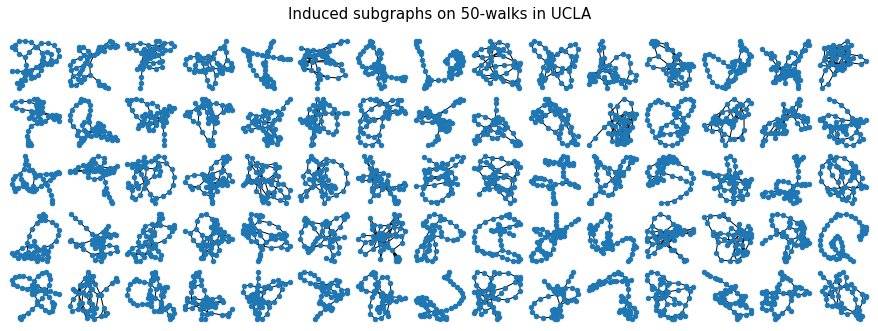

In [3]:
X, embs = G.get_patches(k=k, sample_size=1600, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 1600


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 1

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [201]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.273125


In [202]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [210]:
W_true, H_true = ALS(X = X_true, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 9, # Reconstruction Error reduces as n_components increases
           n_iter = 250, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▌                                          | 3/250 [00:00<00:27,  9.02it/s]

iteration 0, reconstruction error 72321.700720


  8%|███▎                                      | 20/250 [00:00<00:05, 39.37it/s]

iteration 10, reconstruction error 30267.766037
iteration 20, reconstruction error 31300.801303


 16%|██████▋                                   | 40/250 [00:01<00:05, 41.22it/s]

iteration 30, reconstruction error 32155.726111


 18%|███████▌                                  | 45/250 [00:01<00:05, 36.76it/s]

iteration 40, reconstruction error 31818.582820


 23%|█████████▋                                | 58/250 [00:01<00:03, 49.13it/s]

iteration 50, reconstruction error 30733.872312
iteration 60, reconstruction error 29216.115610


 31%|████████████▉                             | 77/250 [00:01<00:03, 49.83it/s]

iteration 70, reconstruction error 27638.546283
iteration 80, reconstruction error 26702.020557


 38%|████████████████▏                         | 96/250 [00:02<00:03, 51.32it/s]

iteration 90, reconstruction error 26379.294419
iteration 100, reconstruction error 26174.304479


 49%|████████████████████                     | 122/250 [00:02<00:01, 67.95it/s]

iteration 110, reconstruction error 26034.203347
iteration 120, reconstruction error 25941.336577


 54%|██████████████████████▎                  | 136/250 [00:03<00:02, 51.43it/s]

iteration 130, reconstruction error 25877.342794


 59%|████████████████████████▎                | 148/250 [00:03<00:02, 46.49it/s]

iteration 140, reconstruction error 25831.481587


 65%|██████████████████████████▌              | 162/250 [00:03<00:01, 54.24it/s]

iteration 150, reconstruction error 25797.849992
iteration 160, reconstruction error 25772.426463


 70%|████████████████████████████▌            | 174/250 [00:03<00:01, 45.90it/s]

iteration 170, reconstruction error 25752.375694


 77%|███████████████████████████████▋         | 193/250 [00:04<00:01, 53.04it/s]

iteration 180, reconstruction error 25736.086195
iteration 190, reconstruction error 25722.697874


 86%|███████████████████████████████████      | 214/250 [00:04<00:00, 60.10it/s]

iteration 200, reconstruction error 25711.449364
iteration 210, reconstruction error 25701.753288


 91%|█████████████████████████████████████▏   | 227/250 [00:04<00:00, 48.84it/s]

iteration 220, reconstruction error 25693.235801


 96%|███████████████████████████████████████▏ | 239/250 [00:05<00:00, 48.96it/s]

iteration 230, reconstruction error 25685.662517
iteration 240, reconstruction error 25678.865848


100%|█████████████████████████████████████████| 250/250 [00:05<00:00, 47.05it/s]




###########################
Shape of W_true: (2500, 9)
###########################




  0%|▏                                          | 1/250 [00:00<00:39,  6.32it/s]

iteration 0, reconstruction error 182263.135305


  6%|██▎                                       | 14/250 [00:00<00:08, 27.60it/s]

iteration 10, reconstruction error 70764.974059


 10%|████▎                                     | 26/250 [00:01<00:08, 25.84it/s]

iteration 20, reconstruction error 74720.115863


 14%|██████                                    | 36/250 [00:01<00:07, 28.42it/s]

iteration 30, reconstruction error 77010.641982


 18%|███████▋                                  | 46/250 [00:01<00:07, 27.79it/s]

iteration 40, reconstruction error 77090.252426


 23%|█████████▋                                | 58/250 [00:02<00:05, 32.12it/s]

iteration 50, reconstruction error 76968.263005


 26%|███████████                               | 66/250 [00:02<00:05, 32.34it/s]

iteration 60, reconstruction error 76643.150501


 30%|████████████▍                             | 74/250 [00:02<00:06, 25.73it/s]

iteration 70, reconstruction error 75873.195902


 34%|██████████████                            | 84/250 [00:03<00:06, 23.93it/s]

iteration 80, reconstruction error 74194.598413


 40%|████████████████▋                         | 99/250 [00:03<00:04, 36.36it/s]

iteration 90, reconstruction error 70955.059489


 41%|████████████████▉                        | 103/250 [00:03<00:04, 29.76it/s]

iteration 100, reconstruction error 66121.048742


 45%|██████████████████▌                      | 113/250 [00:04<00:05, 24.04it/s]

iteration 110, reconstruction error 62588.921553


 49%|████████████████████▏                    | 123/250 [00:04<00:05, 24.08it/s]

iteration 120, reconstruction error 61742.148219


 53%|█████████████████████▊                   | 133/250 [00:04<00:04, 25.26it/s]

iteration 130, reconstruction error 61347.586235


 58%|███████████████████████▊                 | 145/250 [00:05<00:04, 24.61it/s]

iteration 140, reconstruction error 61052.825594


 62%|█████████████████████████▍               | 155/250 [00:05<00:03, 24.53it/s]

iteration 150, reconstruction error 60835.807113


 66%|███████████████████████████              | 165/250 [00:06<00:03, 26.53it/s]

iteration 160, reconstruction error 60675.661651


 70%|████████████████████████████▌            | 174/250 [00:06<00:03, 21.51it/s]

iteration 170, reconstruction error 60556.828859


 74%|██████████████████████████████▏          | 184/250 [00:07<00:02, 24.50it/s]

iteration 180, reconstruction error 60467.180661


 78%|████████████████████████████████▏        | 196/250 [00:07<00:02, 24.17it/s]

iteration 190, reconstruction error 60398.112759


 82%|█████████████████████████████████▌       | 205/250 [00:07<00:01, 23.62it/s]

iteration 200, reconstruction error 60343.273518


 86%|███████████████████████████████████▎     | 215/250 [00:08<00:01, 25.52it/s]

iteration 210, reconstruction error 60298.605404


 90%|████████████████████████████████████▋    | 224/250 [00:08<00:01, 21.75it/s]

iteration 220, reconstruction error 60261.249062


 93%|██████████████████████████████████████▏  | 233/250 [00:09<00:00, 22.18it/s]

iteration 230, reconstruction error 60229.456648


 98%|████████████████████████████████████████ | 244/250 [00:09<00:00, 27.23it/s]

iteration 240, reconstruction error 60201.948624


100%|█████████████████████████████████████████| 250/250 [00:09<00:00, 25.52it/s]




###########################
Shape of W_false: (2500, 9)
###########################




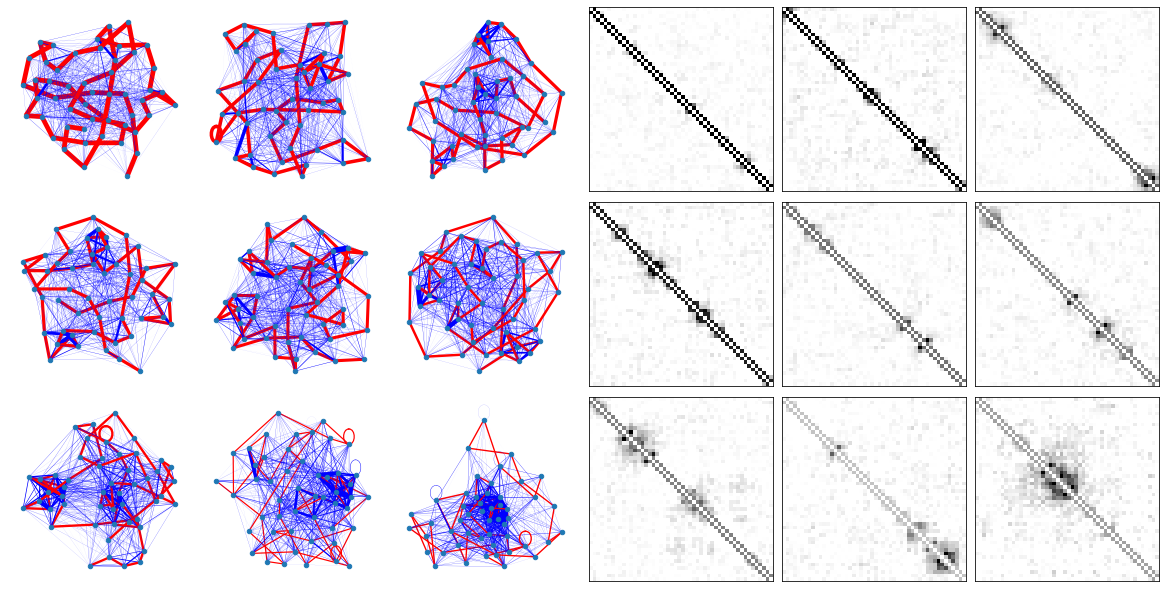

In [211]:
display_dict_and_graph(title=None,
                       save_path='report_figs/NMF_UCLA_True.png',
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

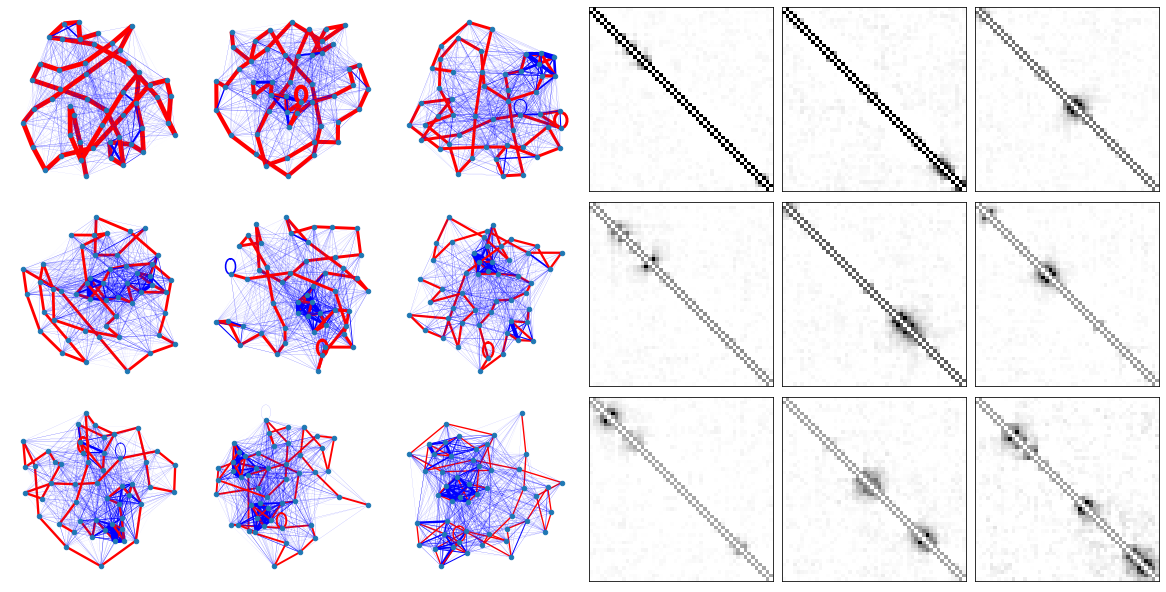

In [212]:
display_dict_and_graph(title=None,
                       save_path='report_figs/NMF_UCLA_False.png',
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [213]:
true_norm = np.linalg.norm(W_true.T, ord=1, axis=1)
false_norm = np.linalg.norm(W_false.T, ord=1, axis=1)

In [214]:
data_arr = np.stack((true_norm, false_norm), axis=0).T
df_boxplot = pd.DataFrame(data_arr, columns = ['Synchronizing','Non-Synchronizing'])
df_boxplot

,Synchronizing,Non-Synchronizing
0,4.995946,4.249973
1,5.066104,4.849367
2,4.335511,4.796982
3,5.386318,5.575539
4,5.502727,4.555146
5,5.949169,4.316270
6,5.292769,5.806940
7,5.403266,5.101850
8,5.251933,4.608039


In [215]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

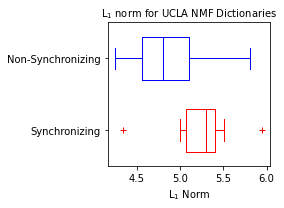

In [237]:
plt.figure(figsize=[4,3])
xlabs = ['Synchronizing', 'Non-Synchronizing']

bs = plt.boxplot(df_boxplot['Synchronizing'], sym='r+', widths=0.6, positions= [0], vert=False)
bns = plt.boxplot(df_boxplot['Non-Synchronizing'], sym='b+', widths=0.6, vert=False)
set_box_color(bs, 'r')
set_box_color(bns, 'b')
plt.yticks(range(len(xlabs)), xlabs, size='medium')
plt.xlabel('L$_1$ Norm', size='medium')
plt.title("L$_1$ norm for UCLA NMF Dictionaries", size="medium")
plt.tight_layout()
plt.savefig('report_figs/NMF_UCLA_Boxplot.png')

In [238]:
true_df_norm = np.linalg.norm(X_true.T, ord=1, axis=1)
false_df_norm = np.linalg.norm(X_false.T, ord=1, axis=1)

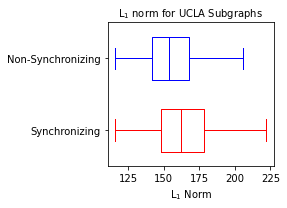

In [251]:
plt.figure(figsize=[4,3])
xlabs = ['Synchronizing', 'Non-Synchronizing']

bs_df = plt.boxplot(true_df_norm, sym='', widths=0.6, positions= [0], vert=False)
bns_df = plt.boxplot(false_df_norm, sym='', widths=0.6, vert=False)
set_box_color(bs_df, 'r')
set_box_color(bns_df, 'b')
plt.yticks(range(len(xlabs)), xlabs, size='medium')
plt.xlabel('L$_1$ Norm', size='medium')
plt.title("L$_1$ norm for UCLA Subgraphs", size="medium")
plt.tight_layout()
plt.savefig('report_figs/Subgraphs_UCLA_Boxplot.png')

In [219]:
df.to_pickle('datasets/ucla_50node_1600examples.pickle')

In [2]:
df = pd.read_pickle('datasets/ucla_50node_1600examples.pickle')

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1596,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1597,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [4]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

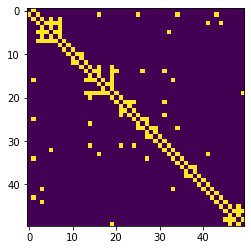

In [11]:
plt.imshow(X_true.T[50].reshape(50, 50))

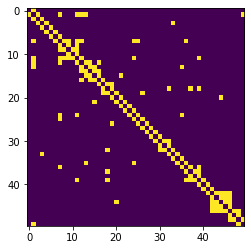

In [12]:
plt.imshow(X_false.T[25].reshape(50, 50))

In [106]:
from imblearn.under_sampling import RandomUnderSampler

X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

rus = RandomUnderSampler(random_state=42)
X_res, Y_res = rus.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, 
                                                    test_size = 0.2,
                                                    stratify = Y_res)

Y_test = Y_test.T.reshape(-1,1)
Y_train = Y_train.T.reshape(-1,1)

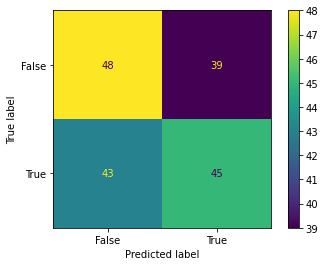

Precision: 0.536
Recall: 0.511
F1: 0.523
Accuracy: 0.531


In [107]:
clf = rf(max_depth=5, max_features="log2").fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

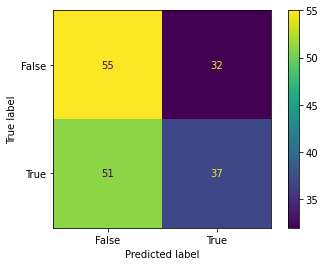

Precision: 0.536
Recall: 0.420
F1: 0.471
Accuracy: 0.526


In [108]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.1, 
                                 max_depth=1, 
                                 random_state=0).fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
model_metrics(clf, Y_test, Y_pred)

In [109]:
# SDL_BCD_feature
data_scale=1
results_dict_list = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.01996255 -0.18519259 -0.32803355  0.87627736  0.68992833  0.82651947
  -0.17201451 -0.02851793  0.05488093  0.90076171]]


 12%|█████▎                                      | 6/50 [00:00<00:00, 57.84it/s]

--- Training --- [threshold, AUC] =  [0.598, 0.565]
--- Iteration 0: Training loss --- [Data, Label, Total] = [232.791024.3, 498.472485.3, 498.472485.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 54.83it/s]

--- Training --- [threshold, AUC] =  [0.999, 0.663]
--- Iteration 10: Training loss --- [Data, Label, Total] = [309.009522.3, 2354.875625.3, 2354.875625.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.48650726  0.6512879   0.67210029  0.06407658 -0.40351687  0.16849183
  -0.5463662   0.07251481 -0.46211176 -0.28018676]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.424, 0.565]
--- Iteration 0: Training loss --- [Data, Label, Total] = [242.583693.3, 492.422938.3, 492.422938.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 53.59it/s]

--- Training --- [threshold, AUC] =  [0.252, 0.618]
--- Iteration 10: Training loss --- [Data, Label, Total] = [360.013969.3, 582.917492.3, 582.917492.3]
Early stopping: training loss increased


!!! pred_type naive
initial loading beta [[-0.39029241  0.50729307  0.12049467 -0.7561132   0.48438298 -0.50259261
  -0.34866963  0.11365061  0.68411495 -0.97028718]]


 14%|██████▏                                     | 7/50 [00:00<00:00, 67.70it/s]

--- Training --- [threshold, AUC] =  [0.38, 0.568]
--- Iteration 0: Training loss --- [Data, Label, Total] = [223.448146.3, 504.993978.3, 527.338793.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 60.13it/s]

--- Training --- [threshold, AUC] =  [0.001, 0.697]
--- Iteration 10: Training loss --- [Data, Label, Total] = [278.447069.3, 2317.128033.3, 2344.972740.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.28769531 -0.59054365 -0.71385306  0.72890858  0.66200336 -0.87943528
  -0.35630199 -0.39483946  0.96417862  0.35147542]]


 18%|███████▉                                    | 9/50 [00:00<00:00, 86.46it/s]

--- Training --- [threshold, AUC] =  [0.544, 0.436]
--- Iteration 0: Training loss --- [Data, Label, Total] = [247.408927.3, 487.341340.3, 512.082233.3]
--- Training --- [threshold, AUC] =  [0.447, 0.702]
--- Iteration 10: Training loss --- [Data, Label, Total] = [297.724624.3, 488.362740.3, 518.135203.3]


 36%|███████████████▍                           | 18/50 [00:00<00:00, 73.41it/s]

--- Training --- [threshold, AUC] =  [0.504, 0.73]
--- Iteration 20: Training loss --- [Data, Label, Total] = [281.060183.3, 484.519973.3, 512.625992.3]


 66%|████████████████████████████▍              | 33/50 [00:00<00:00, 61.50it/s]

--- Training --- [threshold, AUC] =  [0.532, 0.747]
--- Iteration 30: Training loss --- [Data, Label, Total] = [263.385749.3, 485.967967.3, 512.306542.3]


 82%|███████████████████████████████████▎       | 41/50 [00:00<00:00, 65.76it/s]

--- Training --- [threshold, AUC] =  [0.551, 0.76]
--- Iteration 40: Training loss --- [Data, Label, Total] = [246.348657.3, 488.220350.3, 512.855216.3]


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 70.87it/s]


!!! pred_type naive
initial loading beta [[-0.09909398 -0.38248693  0.8935551   0.58261926 -0.15802817 -0.21409772
   0.6146699  -0.92644187  0.15709761  0.03220527]]


 20%|████████▌                                  | 10/50 [00:00<00:00, 91.34it/s]

--- Training --- [threshold, AUC] =  [0.624, 0.565]
--- Iteration 0: Training loss --- [Data, Label, Total] = [223.651379.3, 506.913684.3, 730.565064.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 65.36it/s]


--- Training --- [threshold, AUC] =  [0.998, 0.724]
--- Iteration 10: Training loss --- [Data, Label, Total] = [168.969859.3, 2135.414364.3, 2304.384224.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.49949322 -0.3407247  -0.77237997  0.7417123   0.56656137  0.92293307
   0.03234149 -0.45802216 -0.51727238  0.78411173]]


 12%|█████▎                                      | 6/50 [00:00<00:00, 55.08it/s]

--- Training --- [threshold, AUC] =  [0.71, 0.438]
--- Iteration 0: Training loss --- [Data, Label, Total] = [208.591364.3, 553.009969.3, 761.601334.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 52.91it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.462]
--- Iteration 10: Training loss --- [Data, Label, Total] = [202.918449.3, 3298.153741.3, 3501.072190.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.65020879  0.57613769  0.39804776  0.91718263 -0.2596762   0.12717761
   0.39569067  0.22767758 -0.34500972  0.66179871]]


 16%|███████                                     | 8/50 [00:00<00:00, 74.23it/s]

--- Training --- [threshold, AUC] =  [0.492, 0.436]
--- Iteration 0: Training loss --- [Data, Label, Total] = [198.930994.3, 484.585199.3, 1479.240168.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 59.56it/s]

--- Training --- [threshold, AUC] =  [0.029, 0.576]
--- Iteration 10: Training loss --- [Data, Label, Total] = [101.971702.3, 1246.233747.3, 1756.092257.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.80590955  0.06982769 -0.07621351 -0.05088077  0.89482436 -0.95268254
  -0.81569477 -0.71743905  0.62263021  0.19644489]]


 16%|███████                                     | 8/50 [00:00<00:00, 73.98it/s]

--- Training --- [threshold, AUC] =  [0.377, 0.565]
--- Iteration 0: Training loss --- [Data, Label, Total] = [190.815953.3, 505.997302.3, 1460.077065.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 57.29it/s]

--- Training --- [threshold, AUC] =  [0.014, 0.74]
--- Iteration 10: Training loss --- [Data, Label, Total] = [109.015652.3, 1502.973954.3, 2048.052213.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[-0.0422914   0.28221022 -0.26291306  0.61234791  0.93513676 -0.26162481
   0.1672071  -0.51640852 -0.47101509 -0.94712501]]


 12%|█████▎                                      | 6/50 [00:00<00:00, 54.65it/s]

--- Training --- [threshold, AUC] =  [0.582, 0.563]
--- Iteration 0: Training loss --- [Data, Label, Total] = [185.800578.3, 494.277041.3, 2352.282818.3]


 20%|████████▌                                  | 10/50 [00:00<00:00, 52.94it/s]

--- Training --- [threshold, AUC] =  [0.999, 0.623]
--- Iteration 10: Training loss --- [Data, Label, Total] = [83.608541.3, 2294.885189.3, 3130.970595.3]
Early stopping: training loss increased
!!! pred_type naive


initial loading beta [[ 0.28539799  0.49393626  0.06378274  0.90406398  0.73420689  0.25522872
   0.01865801  0.2307719   0.33283364 -0.48000919]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.425, 0.571]
--- Iteration 0: Training loss --- [Data, Label, Total] = [200.511372.3, 492.412560.3, 2497.526278.3]


 16%|███████                                     | 8/50 [00:00<00:00, 76.94it/s]

--- Training --- [threshold, AUC] =  [0.029, 0.724]
--- Iteration 10: Training loss --- [Data, Label, Total] = [105.090557.3, 1241.161417.3, 2292.066989.3]


 48%|████████████████████▋                      | 24/50 [00:00<00:00, 74.94it/s]

--- Training --- [threshold, AUC] =  [0.098, 0.665]
--- Iteration 20: Training loss --- [Data, Label, Total] = [53.566082.3, 847.703354.3, 1383.364178.3]


 82%|███████████████████████████████████▎       | 41/50 [00:00<00:00, 65.40it/s]

--- Training --- [threshold, AUC] =  [0.125, 0.765]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.480366.3, 772.966069.3, 777.769728.3]
--- Training --- [threshold, AUC] =  [0.111, 0.77]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.346656.3, 809.054954.3, 812.521513.3]


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 70.79it/s]


!!! pred_type naive


In [110]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [111]:
coeff

array([-2.97493559e-03,  3.05157798e-02,  1.09483202e-04,  2.83074857e-04,
        2.10054205e-04,  1.42257566e-04,  1.37814623e-04,  4.42927062e-05,
        2.74335342e-04,  1.91369845e-04])

In [112]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))

Accuracy: 0.5028571428571429


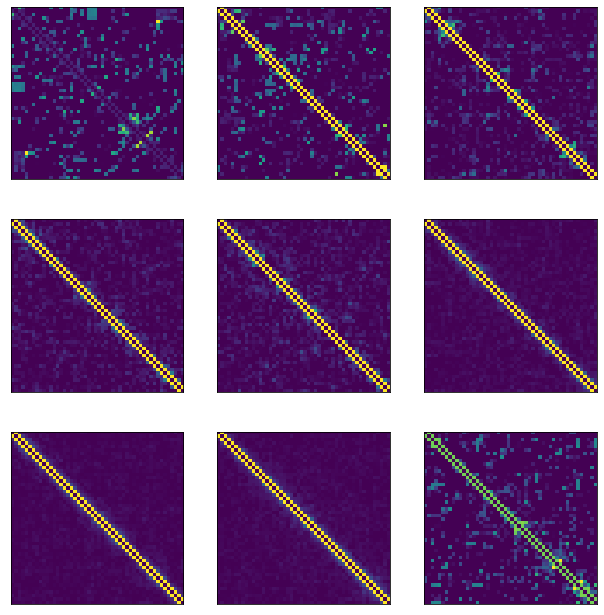

In [113]:
display_dictionary(W = W, figsize=[10,10])

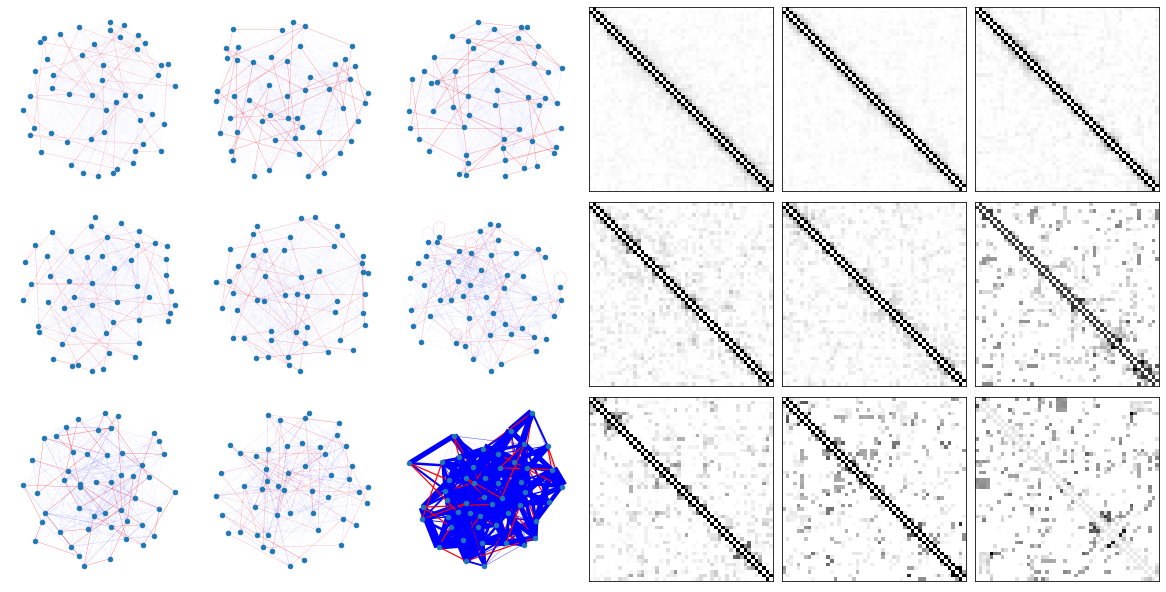

In [114]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       weight_graph = 100, 
                       fig_size = [20,10], 
                       show_importance = True)

In [115]:
# SDL_BCD_filter
data_scale=1
results_dict_list_filter = []
iteration1 = 50
r = 9

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[-0.63801423 -0.2022682  -0.65550552  0.59514402 -0.62424257  0.08073194
  -0.12851057 -0.19686968  0.89040231  0.36897377]]


  2%|▉                                           | 1/50 [00:00<00:06,  7.31it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.597]
--- Iteration 0: Training loss --- [Data, Label, Total] = [125.930671.3, 484.506791.3, 484.506791.3]


 28%|████████████                               | 14/50 [00:00<00:02, 17.13it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.603]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.523652.3, 484.506413.3, 484.506413.3]


 44%|██████████████████▉                        | 22/50 [00:01<00:01, 14.13it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.645]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.430459.3, 484.503105.3, 484.503105.3]


 66%|████████████████████████████▍              | 33/50 [00:02<00:01, 16.25it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.704]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.429996.3, 484.494433.3, 484.494433.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 18.24it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.746]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.434834.3, 484.482804.3, 484.482804.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.51it/s]


!!! pred_type filter
initial loading beta [[-0.85243321  0.95763768 -0.02268239  0.96874257  0.57075931 -0.88503783
  -0.38536945 -0.09973164  0.13458914  0.36818382]]


  4%|█▊                                          | 2/50 [00:00<00:03, 14.80it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.595]
--- Iteration 0: Training loss --- [Data, Label, Total] = [125.559435.3, 484.506882.3, 484.506882.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 18.05it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.601]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.518113.3, 484.506498.3, 484.506498.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 17.99it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.644]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.430519.3, 484.503160.3, 484.503160.3]


 68%|█████████████████████████████▏             | 34/50 [00:01<00:00, 16.88it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.703]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.429649.3, 484.494354.3, 484.494354.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 16.91it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.746]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.434402.3, 484.482674.3, 484.482674.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.63it/s]


!!! pred_type filter
initial loading beta [[ 0.30707046  0.69193679 -0.56330754  0.82993293  0.40828017 -0.12423492
  -0.53811082 -0.71814771  0.03068831  0.92896763]]


  4%|█▊                                          | 2/50 [00:00<00:03, 14.93it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.595]
--- Iteration 0: Training loss --- [Data, Label, Total] = [129.227576.3, 484.506958.3, 497.429716.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 18.18it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.601]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.504637.3, 484.506836.3, 484.557300.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 18.94it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.62]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.283438.3, 484.505776.3, 484.534120.3]


 70%|██████████████████████████████             | 35/50 [00:01<00:00, 18.86it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.64]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.186492.3, 484.504402.3, 484.523051.3]


 86%|████████████████████████████████████▉      | 43/50 [00:02<00:00, 18.21it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.659]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.170851.3, 484.502706.3, 484.519791.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.40it/s]


!!! pred_type filter
initial loading beta [[ 0.38295658  0.31212107  0.88670278  0.99361276 -0.13233871  0.01558968
  -0.50951109 -0.87230095 -0.13986315 -0.30084769]]


  4%|█▊                                          | 2/50 [00:00<00:03, 15.28it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.597]
--- Iteration 0: Training loss --- [Data, Label, Total] = [130.765804.3, 484.506923.3, 497.583503.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 17.97it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.602]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.507492.3, 484.506767.3, 484.557517.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 17.98it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.624]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.291362.3, 484.505542.3, 484.534678.3]


 68%|█████████████████████████████▏             | 34/50 [00:01<00:00, 18.04it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.648]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.190332.3, 484.503883.3, 484.522916.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 17.93it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.668]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.170912.3, 484.501832.3, 484.518923.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.68it/s]


!!! pred_type filter
initial loading beta [[-0.77042637  0.06053923  0.47714635 -0.18703659  0.97041841 -0.85091759
   0.46759444  0.25247046 -0.7547745  -0.39910316]]


  4%|█▊                                          | 2/50 [00:00<00:03, 14.35it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.596]
--- Iteration 0: Training loss --- [Data, Label, Total] = [173.084518.3, 484.507711.3, 657.592228.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 16.21it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.588]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.369397.3, 484.508177.3, 484.877574.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 18.20it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.204314.3, 484.508156.3, 484.712470.3]


 68%|█████████████████████████████▏             | 34/50 [00:01<00:00, 17.96it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.183138.3, 484.508139.3, 484.691276.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 16.78it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.59]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.174786.3, 484.508121.3, 484.682907.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.25it/s]


!!! pred_type filter
initial loading beta [[ 0.39049233  0.99848518 -0.49502409 -0.96486856 -0.18411935  0.86321072
   0.49219082 -0.01426886  0.54319107  0.78524249]]


  4%|█▊                                          | 2/50 [00:00<00:03, 15.50it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.597]
--- Iteration 0: Training loss --- [Data, Label, Total] = [167.284670.3, 484.507644.3, 651.792314.3]


 28%|████████████                               | 14/50 [00:00<00:02, 17.93it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.6]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.331059.3, 484.508040.3, 484.839099.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 17.85it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.601]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.208734.3, 484.508002.3, 484.716736.3]


 66%|████████████████████████████▍              | 33/50 [00:01<00:00, 18.08it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.601]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.188983.3, 484.507975.3, 484.696958.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 14.41it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.602]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.178169.3, 484.507949.3, 484.686118.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.90it/s]


!!! pred_type filter
initial loading beta [[ 0.0477303   0.0615296   0.8247491   0.06144039  0.84716623 -0.726866
  -0.68981101 -0.46229095  0.80332597  0.40730232]]


  0%|                                                    | 0/50 [00:00<?, ?it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.596]
--- Iteration 0: Training loss --- [Data, Label, Total] = [161.314817.3, 484.508759.3, 1291.082842.3]


 28%|████████████                               | 14/50 [00:00<00:02, 16.98it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.579]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.209055.3, 484.508879.3, 485.554153.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 16.38it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.579]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.178289.3, 484.508878.3, 485.400321.3]


 68%|█████████████████████████████▏             | 34/50 [00:02<00:00, 16.70it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.579]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.177854.3, 484.508877.3, 485.398148.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 15.03it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.579]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.177524.3, 484.508876.3, 485.396497.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.15it/s]


!!! pred_type filter
initial loading beta [[-0.70188265 -0.49229299  0.84115139  0.41867558  0.89957986  0.43297172
   0.03708716 -0.78002944 -0.09556333  0.15675356]]


  4%|█▊                                          | 2/50 [00:00<00:03, 12.80it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.6]
--- Iteration 0: Training loss --- [Data, Label, Total] = [163.302075.3, 484.508688.3, 1301.019063.3]


 28%|████████████                               | 14/50 [00:00<00:02, 16.85it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.287574.3, 484.508676.3, 485.946547.3]


 48%|████████████████████▋                      | 24/50 [00:01<00:01, 15.99it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.588]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.181148.3, 484.508674.3, 485.414412.3]


 68%|█████████████████████████████▏             | 34/50 [00:02<00:00, 16.76it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.178338.3, 484.508672.3, 485.400361.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 16.76it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.177820.3, 484.508671.3, 485.397770.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.85it/s]


!!! pred_type filter
initial loading beta [[-0.74116576  0.48879717  0.62460579  0.50984883  0.25873705  0.01218636
  -0.11087269 -0.89573019 -0.87241236  0.90098068]]


  2%|▉                                           | 1/50 [00:00<00:05,  8.23it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.566]
--- Iteration 0: Training loss --- [Data, Label, Total] = [137.811662.3, 484.509164.3, 1862.625787.3]


 26%|███████████▏                               | 13/50 [00:00<00:02, 16.88it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.455355.3, 484.509163.3, 489.062717.3]


 46%|███████████████████▊                       | 23/50 [00:01<00:01, 15.63it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.448925.3, 484.509163.3, 488.998418.3]


 68%|█████████████████████████████▏             | 34/50 [00:02<00:00, 17.26it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.448729.3, 484.509163.3, 488.996456.3]


 88%|█████████████████████████████████████▊     | 44/50 [00:02<00:00, 16.78it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.589]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.448537.3, 484.509163.3, 488.994531.3]


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.54it/s]


!!! pred_type filter
initial loading beta [[ 0.28111955  0.38455814  0.21178099 -0.08138682 -0.40564475  0.75365124
   0.91775778  0.28119399 -0.96797457 -0.07253582]]


  4%|█▊                                          | 2/50 [00:00<00:02, 16.99it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.571]
--- Iteration 0: Training loss --- [Data, Label, Total] = [109.753290.3, 484.509164.3, 1582.042060.3]


 28%|████████████                               | 14/50 [00:00<00:02, 17.77it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.55]
--- Iteration 10: Training loss --- [Data, Label, Total] = [0.449053.3, 484.509164.3, 488.999689.3]


 44%|██████████████████▉                        | 22/50 [00:01<00:01, 16.86it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.55]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.449071.3, 484.509164.3, 488.999876.3]


 66%|████████████████████████████▍              | 33/50 [00:01<00:00, 17.11it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.551]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.448952.3, 484.509164.3, 488.998686.3]


 86%|████████████████████████████████████▉      | 43/50 [00:02<00:00, 17.05it/s]

--- Training --- [threshold, AUC] =  [0.499, 0.551]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.448845.3, 484.509164.3, 488.997611.3]


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.53it/s]


!!! pred_type filter


In [116]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [117]:
coeff

array([-2.86152685e-03,  7.89710831e-07,  8.16624705e-07,  4.87193133e-05,
        6.86267353e-07,  5.96148750e-07,  7.31620456e-07,  8.69722106e-07,
        5.82294264e-07,  8.82982987e-07])

In [118]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))

Accuracy: 0.5142857142857142


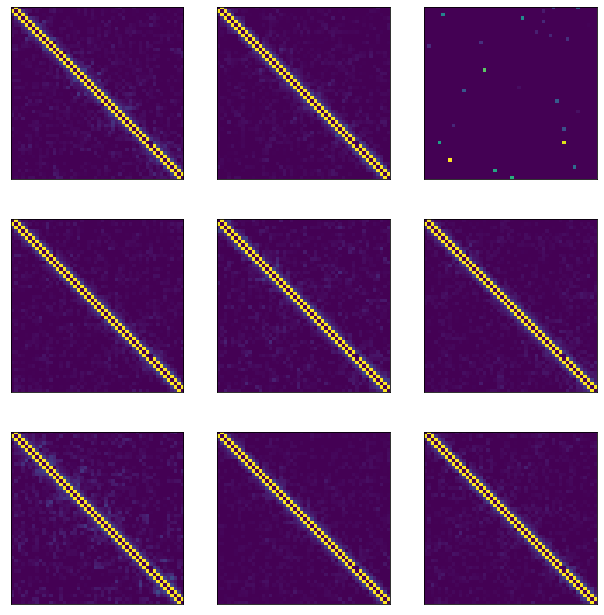

In [119]:
display_dictionary(W = W, figsize=[10,10])